# EXPLORING CORRELATIONS BETWEEN GENERAL PROPERTIES OF LIGAND BINDING SITES

In this notebook we explore correlations between RSA, Shenkin, and Missense enrichment score and binding site size.

### IMPORTING NECESSARY PACKAGES

In [2]:
from fragsys_analysis import *

In [3]:
main_dir = "./../"
results_dir = os.path.join(main_dir, "results")
figs_dir = os.path.join(main_dir, "figs")

In [4]:
all_prots = pd.read_pickle(os.path.join(results_dir, "all_prots.pkl"))
all_bs_ress = pd.read_pickle(os.path.join(results_dir, "all_bs_ress.pkl"))
all_bss = pd.read_pickle(os.path.join(results_dir, "all_bss.pkl"))

In [5]:
all_bs_ress.head(3)

,index,UniProt_ResNum,Pfam_column,alignment_column,shenkin,occ,gaps,occ_pct,gaps_pct,rel_norm_shenkin,...,BS14,BS15,BS16,BS17,BS18,BS19,BS20,BS21,BS22,BS23
0,52,101,79,79,76.106280,389,207,0.652685,0.347315,75.041931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62,106,85,85,58.693017,389,207,0.652685,0.347315,56.402733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,212,190,317,317,52.334433,240,356,0.402685,0.597315,49.596489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
rsa_profs = get_rsa_profiles(all_bss, all_bs_ress)
average_rsas = [statistics.median(v) for v in rsa_profs.values()]
all_bs_ress_filt = all_bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])

In [8]:
print("Number of proteins: {}".format(len(all_prots.drop_duplicates(["acc"]))))
print("Number of protein segments: {}".format(len(all_prots.drop_duplicates(["acc", "group"]))))
print("Number of structures: {}".format(all_prots.n_strucs.sum()))
print("Number of ligands of interest: {}".format(all_prots.n_ligs.sum()))
print("Number of defined binding sites: {}".format(all_prots.n_bs.sum()))
print("Number of binding site residues: {}".format(len(all_bs_ress_filt)))

Number of proteins: 35
Number of protein segments: 37
Number of structures: 1309
Number of ligands of interest: 1601
Number of defined binding sites: 292
Number of binding site residues: 2664


## PRE-PROCESSING FOR THE REGRESSION + BOX PLOTS

In [38]:
binns3 = [
    (1, 6), (6, 9), (9, 11), (11, 13),
    (13, 16), (16, 21), (21, 41)
]

In [9]:
all_bss["lab"] = all_bss.protein + "_" + all_bss.group.astype(str) + "_" + all_bss.bs_id

In [10]:
all_bss_filt = all_bss.copy()[all_bss.lab.isin(rsa_profs.keys())]
all_bss_filt.index = range(len(all_bss_filt))

In [41]:
bins_list = bin_data_points(all_bss_filt, "number_bs_res", binns3)

all_bss_filt["number_bs_res_binned"] = bins_list

all_bss_filt.number_bs_res_binned = all_bss_filt.number_bs_res_binned.astype(str)
binns3 = [str(el) for el in binns3]
un_bs_sizes = list(set(all_bss_filt.number_bs_res.tolist()))

new_x = [-0.5+0.2*(n-1) for n in un_bs_sizes]

## SITE AVERAGE RSA VS SITE SIZE

In [42]:
#new_rsa_means = [statistics.mean(list(v)) for v in rsa_profs.values()]
new_rsa_medians = [statistics.median(v) for v in rsa_profs.values()]

In [43]:
X =  np.array(all_bss_filt.number_bs_res.tolist())
Y = np.array(new_rsa_medians)
m, b = np.polyfit(X, Y, 1)

new_y_rsa = sorted(list(set(list(m*X+b))), reverse = True)

R = pearsonr_ci(X, Y)

r = -0.4, p = 0.0, 95% CI = [-0.49, -0.3]


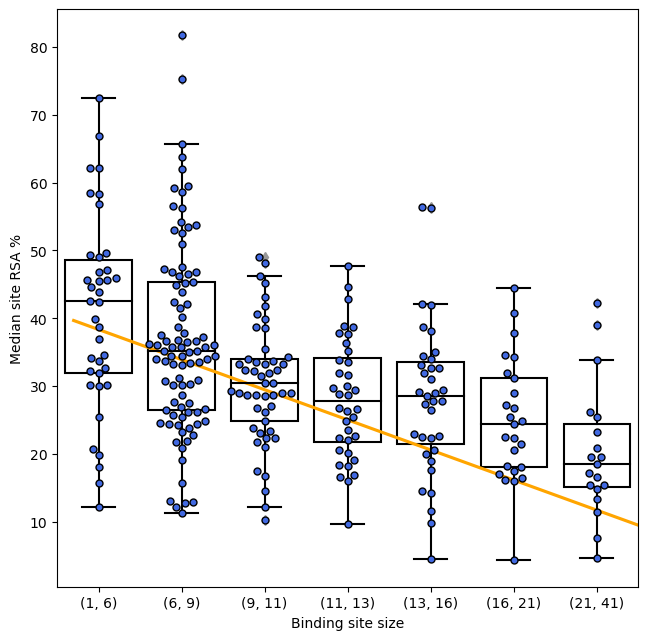

In [49]:
plot_reg_boxes(
    new_x, sorted(new_y_rsa, reverse = True),
    all_bss_filt.number_bs_res_binned, new_rsa_medians, binns3,
    xlab = "Binding site size", ylab = "Median site RSA %",
    f_size = (7.5, 7.5), dpi = 100,
    #out = os.path.join(figs_dir, "RSA_v_size.png")
)

## SITE AVERAGE DIVERGENCE VS SITE SIZE

In [13]:
reg_y_shenkin = regression_coordinates(all_bss_filt, "number_bs_res", "norm_shenkin_rel")
new_y_shenkin = sorted(list(set(list(reg_y_shenkin))), reverse = True)

R = pearsonr_ci(all_bss_filt.number_bs_res, all_bss_filt.norm_shenkin_rel)

r = -0.21, p = 0.0003, 95% CI = [-0.32, -0.1]


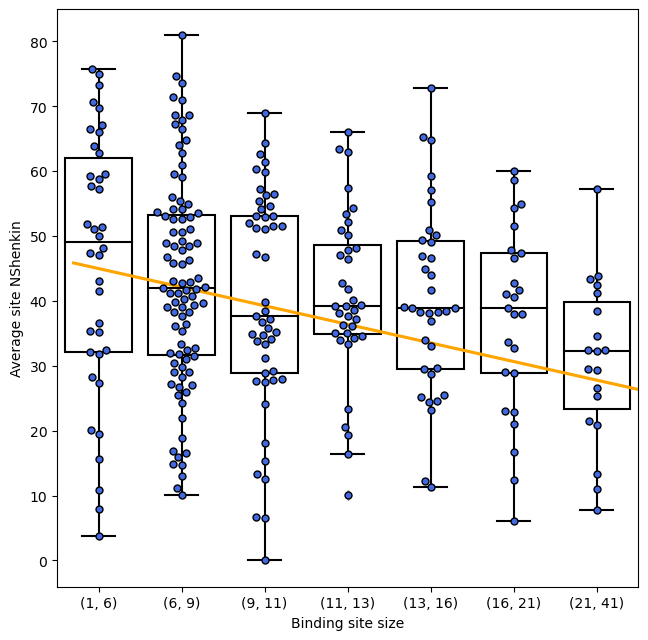

In [14]:
plot_reg_boxes(
    new_x, sorted(new_y_shenkin, reverse = True),
    all_bss_filt.number_bs_res_binned, all_bss_filt.norm_shenkin_rel, binns3,
    xlab = "Binding site size", ylab = "Average site NShenkin",
    f_size = (7.5, 7.5), dpi = 100,
    #out = os.path.join(figs_dir, "shenk_v_size.png")
)

## SITE AVERAGE MES VS SITE SIZE

In [15]:
reg_y_mes = regression_coordinates(all_bss_filt, "number_bs_res", "MES")
new_y_mes = sorted(list(set(list(reg_y_mes))), reverse = True)

R = pearsonr_ci(all_bss_filt.number_bs_res, all_bss_filt.MES)

r = -0.15, p = 0.0082, 95% CI = [-0.26, -0.04]


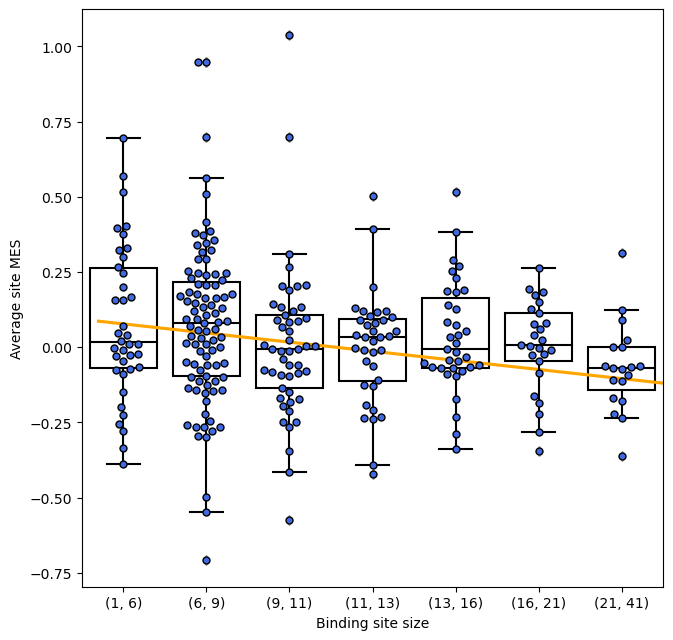

In [16]:
plot_reg_boxes(
    new_x, sorted(new_y_mes, reverse = True),
    all_bss_filt.number_bs_res_binned, all_bss_filt.MES, binns3,
    xlab = "Binding site size", ylab = "Average site MES",
    f_size = (7.5, 7.5), dpi = 100,
    #out = os.path.join(figs_dir, "mes_v_size.png")
)

### NO CORRELATION BETWEEN AVERAGE SITE NSHENKIN AND MES

r = 0.0, p = 0.9547, 95% CI = [-0.11, 0.12]


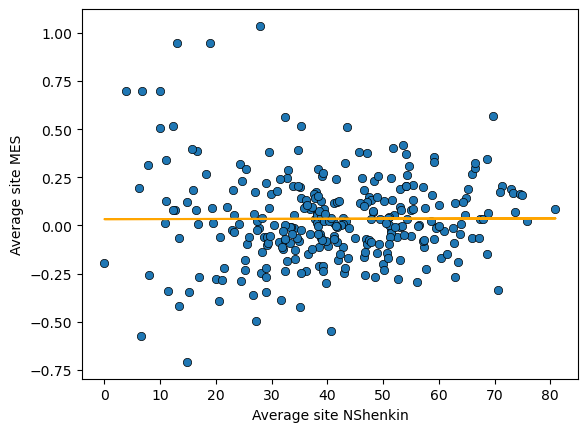

In [47]:
ezy_scatter(np.array(all_bss_filt.norm_shenkin_rel),
            np.array(all_bss_filt.MES),
            "Average site NShenkin",
            "Average site MES"
           )